In [1]:
import csv
import requests
import pandas as pd
import matplotlib
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from io import BytesIO
from PIL import Image

Loading and opening the dataset with blurbs:

In [2]:
b_books = pd.read_csv('books_with_blurbs.csv', delimiter=',')
b_books.head()

,ISBN,Title,Author,Year,Publisher,Blurb
0,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...


In [3]:
b_books.shape

(57492, 6)

In [4]:
b_books.drop_duplicates(subset='Title', keep="first")

,ISBN,Title,Author,Year,Publisher,Blurb
0,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...
...,...,...,...,...,...,...
57486,812511654,Empire Builders (The Grand Tour),Ben Bova,1995,Tor Science Fiction,Dan Randolph never plays by the rules. A hell-...
57487,451458877,Tainted Trail,Wen Spencer,2002,Roc,"Ukiah Oregon, half-man and half-alien raised b..."
57489,399148841,The Man With the Red Tattoo (James Bond 007),Raymond Benson,2002,Putnam Publishing Group,On a quiet late-night flight from Tokyo to Lon...
57490,553578979,"Iron Fist (Star Wars: X-Wing Series, Book 6)",Aaron Allston,1998,Bantam,They are the Rebel Alliance's ultimate strike ...


Loading the data from the Book-Crossing dataset (http://www2.informatik.uni-freiburg.de/~cziegler/BX/).
First, let's look at the "BX-Books" table:

In [5]:
all_books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
all_books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 
                 'imageUrlS', 'imageUrlM', 'imageUrlL']
all_books.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
c:\users\anastask\appdata\local\programs\python\python37\lib\site-packages

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
all_books.shape

(271360, 8)

Merging the two datasets to have more data:

In [7]:
merged = pd.merge(b_books, all_books, how='inner', on=['ISBN'])
#merged.head()

The resulting dataframe has redundant (repeated) columns. Let's select the columns of interest:

In [8]:
books = merged[['ISBN', 'Title', 'Author', 'Year', 'Publisher', 'Blurb', 'imageUrlL']]
books.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL
0,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...
1,1841721522,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd,Filled with fresh and eclectic recipes by Celi...,http://images.amazon.com/images/P/1841721522.0...
2,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon,A most unusual death has landed Helma Zukas ri...,http://images.amazon.com/images/P/038078243X.0...
3,042518630X,Purity in Death,J.D. Robb,2002,Berkley Publishing Group,Louie Cogburn had spent three days holed up in...,http://images.amazon.com/images/P/042518630X.0...
4,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,Maggie Moran's mission is to connect and unite...,http://images.amazon.com/images/P/042511774X.0...


In [9]:
books.shape

(12356, 7)

Some user analysis (not really needed since I don't use user information further):

In [10]:
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Book ratings:

In [11]:
all_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
all_ratings.columns = ['userID', 'ISBN', 'bookRating']
all_ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
all_ratings.shape

(1149780, 3)

In [13]:
average_rating = pd.DataFrame(all_ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(all_ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


In [14]:
average_rating.shape

(340556, 2)

Combining book data with rating data:

In [15]:
books = pd.merge(books, average_rating, how='inner', on=['ISBN'])
books.rename(columns={'bookRating':'averageRating'}, inplace=True)
books.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount
0,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...,4.666667,3
1,1841721522,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd,Filled with fresh and eclectic recipes by Celi...,http://images.amazon.com/images/P/1841721522.0...,2.000000,37
2,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon,A most unusual death has landed Helma Zukas ri...,http://images.amazon.com/images/P/038078243X.0...,1.444444,9
3,042518630X,Purity in Death,J.D. Robb,2002,Berkley Publishing Group,Louie Cogburn had spent three days holed up in...,http://images.amazon.com/images/P/042518630X.0...,2.320755,106
4,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,Maggie Moran's mission is to connect and unite...,http://images.amazon.com/images/P/042511774X.0...,1.870588,170


In [16]:
# Removing books with low number of ratings 
indexNames = books[books['ratingCount'] < 2 ].index
books.drop(indexNames, inplace=True)
books.shape
#books.head()

(9138, 9)

In [17]:
books[['averageRating', 'ratingCount']].describe()

,averageRating,ratingCount
count,9138.000000,9138.000000
mean,3.960079,9.907529
std,1.974301,23.342215
min,0.142857,2.000000
25%,2.500000,3.000000
50%,3.571429,5.000000
75%,5.000000,9.000000
max,10.000000,647.000000


## Some data visualizations:

In [18]:
# Calculating the word count for blurbs
books['wordCount'] = books['Blurb'].apply(lambda x: len(str(x).split()))
books.head()
# Saving the data into a csv table
path = 'C:/Users/anastask/OneDrive - NTNU/TDT4310/Project/books.csv'
books.to_csv(path, index=False, encoding='utf-8-sig')

In [19]:
books['wordCount'].describe()

count    9138.000000
mean      115.558328
std        81.865282
min         2.000000
25%        57.000000
50%       101.000000
75%       153.000000
max      2679.000000
Name: wordCount, dtype: float64

There is one extreme book blurb consisting of 2679 words (which turned out to be in French) and some amount of books with really short descriptions (with the minimum of one, and it turned out to be some Japanese characters which were perceived as one word). Anyway, since really short blurbs probably are not very informative (or are not proper blurbs at all), let's get rid of those, together with extremely long blurbs. I have set a treshold of 50 words minimum (which is around the first quantile) and 500 words maximum:

In [20]:
books1 = books.loc[books['wordCount'].isin(range(50,500))]
books1.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount,wordCount
0,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...,4.666667,3,268
1,1841721522,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd,Filled with fresh and eclectic recipes by Celi...,http://images.amazon.com/images/P/1841721522.0...,2.000000,37,131
2,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon,A most unusual death has landed Helma Zukas ri...,http://images.amazon.com/images/P/038078243X.0...,1.444444,9,88
3,042518630X,Purity in Death,J.D. Robb,2002,Berkley Publishing Group,Louie Cogburn had spent three days holed up in...,http://images.amazon.com/images/P/042518630X.0...,2.320755,106,131
4,042511774X,Breathing Lessons,Anne Tyler,1994,Berkley Publishing Group,Maggie Moran's mission is to connect and unite...,http://images.amazon.com/images/P/042511774X.0...,1.870588,170,132


In [21]:
books1.shape

(7309, 10)

Let's plot the wordcount for the remaining books:

Text(0, 0.5, 'Number of books')

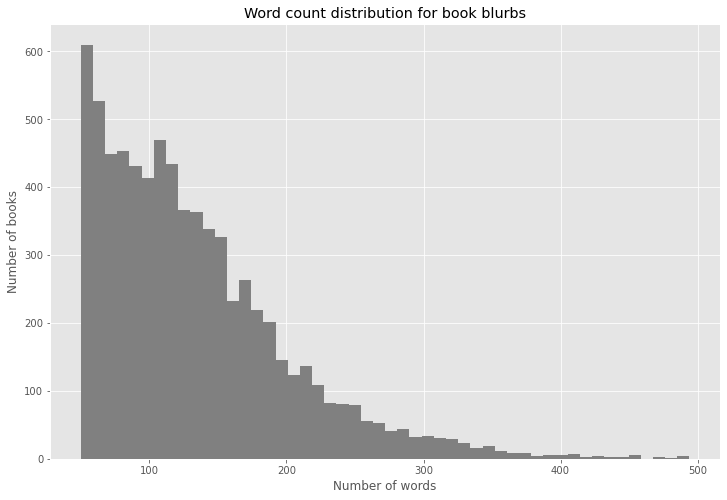

In [22]:
# Plotting the word count
pl = books1['wordCount'].plot(kind='hist', bins=50, figsize=(12,8), color='Grey',
                        title='Word count distribution for book blurbs')
pl.set_xlabel('Number of words')
pl.set_ylabel('Number of books')

In [23]:
# Converting books descriptions into vectors using TF-IDF based on bigrams
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books1['Blurb'])
total_words = tfidf_matrix.sum(axis=0) 

In [24]:
# Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

In [25]:
# Converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'Bigram', 1: 'Count'}, inplace = True)
bigram.head(10)

,Bigram,Count
0,New York,20.799089
1,year old,16.389949
2,This book,10.928434
3,en la,10.467851
4,en el,10.160900
5,qu il,8.267380
6,York Times,7.559543
7,young woman,7.463572
8,years ago,7.374616
9,bestselling author,7.080979


Text(0, 0.5, 'Bigram frequency count')

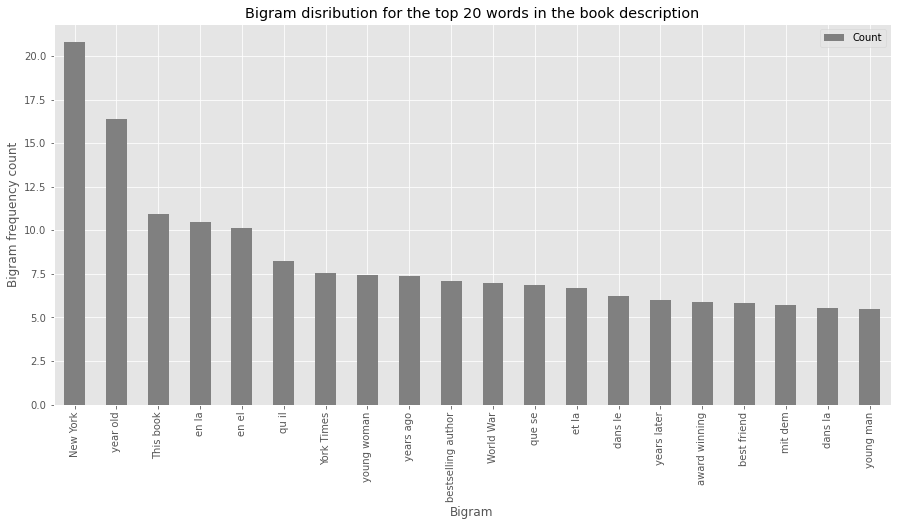

In [26]:
# Taking first 20 records
bigram = bigram.head(20)
#Plotting the bigram distribution
pl2 = bigram.plot(x='Bigram', y='Count', kind='bar', color='Grey',
            title ="Bigram disribution for the top 20 words in the book description", figsize = (15,7), )
pl2.set_ylabel('Bigram frequency count')

## Content-based recommendation system
First, let's pre-process the blurbs for subsequent vectorization: get rid of stop words, punctuation, links, numbers etc.:

In [27]:
# Put text in lowercase, get rid of links, numbers, punctuation, @UserNames(if there are any)
books2 = books1.copy()
books2['cleanedBlurb'] = books2['Blurb'].str.lower()
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'@\w+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'http\S+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'www.[^ ]+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'[0-9]+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)

In [28]:
# Remove the stopwords
books2['cleanedBlurb'] = books2['cleanedBlurb'].fillna("").astype('str')
stop_words = set(stopwords.words('english'))
books2['cleanedBlurb'] = books2['cleanedBlurb'].apply(lambda x: ' '.join([word for word in x.split() 
                                                                          if word not in stop_words]))
#books2.head()

When calculating the cosine similarity values between a large number of vectors, one is likely to encounter a memory error due to computing power restrictions of their machine. In my case, calculating similarity matrix for 31 k books was not a problem (but I encountered problems when calculating it on a larger dataset).

In [29]:
#books3 = books2.sample(frac=0.8)
books3 = books2
books3 = books3.reset_index(drop=True)
#books3.shape
count_sorted = books3.sort_values(by = 'averageRating', ascending = False)
count_sorted.head(50)

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount,wordCount,cleanedBlurb
6513,3442120772,SchlÃ?Â¼sselworte zum Tarot.,Hajo Banzhaf,1999,Goldmann,"In September 1960, John Steinbeck embarked on...",http://images.amazon.com/images/P/3442120772.0...,10.0,2,289,september john steinbeck embarked journey acro...
6394,229012950X,"La Tour sombre, tome 1 : Le pistolero",Stephen King,2000,J'ai lu,""" L'homme en noir fuyait à travers le désert, ...",http://images.amazon.com/images/P/229012950X.0...,10.0,2,127,l'homme en noir fuyait à travers le désert et ...
5399,1892213605,Gundam Wing #3,Koichi Tokita,2001,Tokyopop,"Gundam Wing, which airs nationally on Cartoon ...",http://images.amazon.com/images/P/1892213605.0...,10.0,2,63,gundam wing airs nationally cartoon network pr...
4825,1401300227,Jamie's Kitchen,Jamie Oliver,2003,Hyperion,--the television show--began as an experiment ...,http://images.amazon.com/images/P/1401300227.0...,10.0,2,181,television showbegan experiment turned phenome...
3247,3426625083,Das achte Opfer. Sonderausgabe.,Andreas Franz,2003,"Droemersche Verlagsanstalt Th. Knaur Nachf., G...",Ein Unbekannter schickt der Frankfurter Kripo ...,http://images.amazon.com/images/P/3426625083.0...,10.0,2,73,ein unbekannter schickt der frankfurter kripo ...
6163,1569714029,300,Frank Miller,1999,Dark Horse Comics,The armies of Persia—a vast horde greater than...,http://images.amazon.com/images/P/1569714029.0...,10.0,2,82,armies persia—a vast horde greater world ever ...
5372,1561709336,Power vs. Force: The Hidden Determinants of Hu...,David R. Hawkins,2002,Hay House,David R. Hawkins details how anyone may resolv...,http://images.amazon.com/images/P/1561709336.0...,10.0,3,75,david r hawkins details anyone may resolve cru...
4546,1593080344,"The Complete Sherlock Holmes, Vol. I (Barnes &...",Arthur Conan Doyle,2003,Barnes &amp; Noble Books-Imports,"Eccentric, arrogant, and ingenious, Sherlock H...",http://images.amazon.com/images/P/1593080344.0...,10.0,2,153,eccentric arrogant ingenious sherlock holmes r...
4827,044036499X,Not Wanted on the Voyage,Timonthy Findley,1987,Dell Publishing Company,"Published in 1984, , is one of Timothy Findley...",http://images.amazon.com/images/P/044036499X.0...,10.0,2,207,published one timothy findley's imaginative co...
3126,2080106325,Collectible Miniature Perfume Bottles (Collect...,Anne Breton,2002,Flammarion-Pere Castor,"Famous perfumers, fashion designer film stars,...",http://images.amazon.com/images/P/2080106325.0...,10.0,2,120,famous perfumers fashion designer film stars c...


Now let's vectorize the book descriptions. This step will take some time:

In [30]:
# Converting books descriptions into vectors using TF-IDF
tf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books3['cleanedBlurb'])
tfidf_matrix.shape

(7309, 545045)

Now let's calculate the cosine similarity between vectors (likely to encounter a memory error here if there are too many vectors):

In [31]:
#Function for calculating the cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(7309, 7309)

Let's build a 1-dimensional array of book titles to be able to lookup similar books by typing in their title:

In [32]:
# Build a 1-dimensional array with book titles
titles = books3['Title']
indices = pd.Series(books3.index, index=books3['Title'])
indices.head()

Title
Goodbye to the Buttermilk Sky                                    0
New Vegetarian: Bold and Beautiful Recipes for Every Occasion    1
Miss Zukas and the Raven's Dance                                 2
Purity in Death                                                  3
Breathing Lessons                                                4
dtype: int64

In [33]:
def recommend(title):
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6] # let's take five most similar items
        book_indices = [i[0] for i in sim_scores]
        
        recommendations = books3[['Title', 'imageUrlL', 'Author', 'Blurb']].iloc[book_indices] #recommended books
        df = recommendations[['Title', 'Author']]
        print(df.to_string(index=False))
            
        images = []
        for i in recommendations['imageUrlL']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            images.append(img)
            
        # Ugly piece of code to show images 
        # It needs to be re-written as a function (but matplotlib is pain so I will leave it like this for now)
        fig = plt.figure()
        a = fig.add_subplot(1, 5, 1)
        imgplot = plt.imshow(images[0])
        a = fig.add_subplot(1, 5, 2)
        imgplot = plt.imshow(images[1])
        a = fig.add_subplot(1, 5, 3)
        imgplot = plt.imshow(images[2])
        a = fig.add_subplot(1, 5, 4)
        imgplot = plt.imshow(images[3])
        a = fig.add_subplot(1, 5, 5)
        imgplot = plt.imshow(images[4])
    except KeyError:
        print('Seems like this book is not in the database. Try another one!')
    

                                                                                                              Title         Author
 Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry  J. K. Rowling
                                                            Harry Potter and the Prisoner of Azkaban (Harry Potter)   J.K. Rowling
                                                                                                      Die Prozedur.  Harry Mulisch
                                                                 Harry Potter and the Order of the Phoenix (Book 5)  J. K. Rowling
                                                                                              We Love Harry Potter!   Sharon Moore


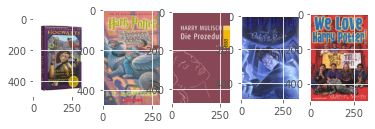

In [34]:
recommend("Harry Potter and the Chamber of Secrets")

                                                   Title                     Author
                            Cooking for a Healthy Family                 Simon Hope
                       Recipes From A Vegetarian Goddess              Karri Allrich
                                         Shadow of Doubt           Terri Blackstock
 Vegetarian Meals in Minutes (Australian Women's Weekly)  Australian Women's Weekly
                     Meatless Cooking (Company's Coming)                  Jean Pare


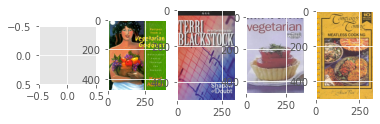

In [35]:
recommend("New Vegetarian: Bold and Beautiful Recipes for Every Occasion")